# Zurich Instruments Lock-In MFLI Data Aquesition

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [25]:
import matplotlib.pyplot as plt

In [3]:
from zhinst import ziPython as zhinst_core

In [13]:
import qupulse

In [4]:
from qupulse.hardware.dacs.mfli import MFLIDAQ

z:\git\qupulse\qupulse\hardware\awgs\tektronix.py:13: UserWarning: Could not import Tektronix driver backend. If you wish to use it execute qupulse.hardware.awgs.install_requirements('tektronix')
  warnings.warn("Could not import Tektronix driver backend. "


In [5]:
my_lockin = MFLIDAQ(device_serial="dev3442", device_interface="PCIe", data_server_addr="192.168.53.202")

In [9]:
my_lockin.register_measurement_channel(program_name="test", channel_path=["demods/0/sample.R", "auxins/0/sample.AuxIn0.avg", "demods/0/sample.X", "demods/0/sample.Y"])

In [10]:
my_lockin.register_measurement_windows(program_name="test", windows={"a": (np.array([0, 3])*1, np.array([1, 10])*1),"b": (np.array([0, 2, 4])*1e-3, np.array([1, 4, 6.1])*1e-3)})

In [11]:
my_lockin.programs

{'test': {'channels': ['demods/0/sample.R',
   'auxins/0/sample.AuxIn0.avg',
   'demods/0/sample.X',
   'demods/0/sample.Y'],
  'windows': {'a': (array([0, 3]), array([ 1, 10])),
   'b': (array([0.   , 0.002, 0.004]), array([0.001 , 0.004 , 0.0061]))},
  'masks': {'a': array([[[    0.,    nan,     0.,     0.],
           [ 5022.,    nan,  5022.,  5022.]],
   
          [[ 1674.,    nan,  1674.,  1674.],
           [16741.,    nan, 16741., 16741.]],
   
          [[ 1674.,    nan,  1674.,  1674.],
           [21763.,    nan, 21763., 21763.]]]),
   'b': array([[[ 0., nan,  0.,  0.],
           [ 3., nan,  3.,  3.],
           [ 7., nan,  7.,  7.]],
   
          [[ 1., nan,  1.,  1.],
           [ 6., nan,  6.,  6.],
           [10., nan, 10., 10.]],
   
          [[ 1., nan,  1.,  1.],
           [ 9., nan,  9.,  9.],
           [17., nan, 17., 17.]]])}}}

## Defining a simple qupulse pulse with a measurement window.

In [111]:
from qupulse.pulses.plotting import plot

In [21]:
red_pulse = qupulse.pulses.TablePT({"red": [
    (0, 0),
    (1, 4, 'hold'),
    (4, .5, 'linear'),
    (5, 2, 'hold'),
    (6, .5, 'hold'),
    (15, .5, 'jump'),
]})

In [52]:
green_pulse = qupulse.pulses.SequencePT(*[
    qupulse.pulses.FunctionPT(".1", "6", channel="green"),
    qupulse.pulses.FunctionPT(".1+t**2*.9", "1", channel="green"),
    qupulse.pulses.FunctionPT("1", "1", channel="green"),
    qupulse.pulses.FunctionPT("1+sin(t*2*pi)*exp(-(t-2)**2)", "5", channel="green"),
    qupulse.pulses.FunctionPT("1", "1", channel="green"),
    qupulse.pulses.FunctionPT("0", "1", channel="green"),
]
)

In [137]:
measured_pt = qupulse.pulses.PointPT([(0, 0), (0, 1), (15, 1), (15, 0)],
                      channel_names=("trigger_out",),
                      measurements=[('A', 3, 1.5), ('A', 12, 3), ('R', 6.5, 1.4), ('R', 14, 1), ('T', 10, 3)])

In [138]:
combined_pulse = red_pulse+green_pulse+measured_pt

z:\git\qupulse\qupulse\pulses\arithmetic_pulse_template.py:72: ImplicitAtomicityInArithmeticPT: ArithmeticAtomicPulseTemplate treats all operands as if they are atomic. You can silence this warning by passing `silent_atomic=True` or by ignoring this category.
  category=ImplicitAtomicityInArithmeticPT)


In [139]:
print(combined_pulse.measurement_names)
print(combined_pulse.measurement_declarations)
print(combined_pulse.measurement_parameters)

{'T', 'R', 'A'}
[]
set()


In [140]:
combined_pulse.get_measurement_windows

<bound method ArithmeticAtomicPulseTemplate.get_measurement_windows of ((TablePulseTemplate(entries={'red': [(0, 0, 'hold'), (1, 4, 'hold'), (4, 0.5, 'linear'), (5, 2, 'hold'), (6, 0.5, 'hold'), (15, 0.5, 'jump')]},parameter_constraints=[],measurements=[]) '+' SequencePulseTemplate(subtemplates=[FunctionPulseTemplate(duration_expression=ExpressionScalar('6'),expression=ExpressionScalar('.1'),channel='green',measurements=[],parameter_constraints=[]), FunctionPulseTemplate(duration_expression=ExpressionScalar('1'),expression=ExpressionScalar('.1+t**2*.9'),channel='green',measurements=[],parameter_constraints=[]), FunctionPulseTemplate(duration_expression=ExpressionScalar('1'),expression=ExpressionScalar('1'),channel='green',measurements=[],parameter_constraints=[]), FunctionPulseTemplate(duration_expression=ExpressionScalar('5'),expression=ExpressionScalar('1+sin(t*2*pi)*exp(-(t-2)**2)'),channel='green',measurements=[],parameter_constraints=[]), FunctionPulseTemplate(duration_expression=

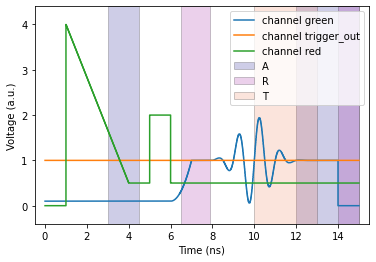

In [142]:
plot(combined_pulse, sample_rate=300, plot_measurements=combined_pulse.measurement_names) # combined_pulse.measurement_names
plt.show()

In [143]:
idle_pulse = qupulse.pulses.TablePT({"red": [
    (0, 0),
    (5, 0),
],
                                     "green": [
    (0, 0),
    (5, 0),
],
                                     "trigger_out": [
    (0, 0),
    (5, 0),
]})

In [144]:
rep = qupulse.pulses.repetition_pulse_template.RepetitionPulseTemplate(
    body=qupulse.pulses.SequencePT(combined_pulse, idle_pulse),
    repetition_count=10
)

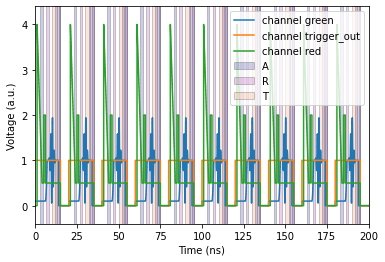

In [145]:
plot(rep, sample_rate=300, plot_measurements=combined_pulse.measurement_names)
plt.show()

## Execution

1. map output channels to dummy instrument
2. arm scan and see if everything works

In [146]:
from qupulse.hardware.setup import HardwareSetup, MeasurementMask

In [150]:
setup = HardwareSetup()

In [151]:
for n in ["R", "T", "A"]:
    setup.set_measurement(f"{n}_lockin", MeasurementMask(my_lockin, n))

In [156]:
# for c in ["red", "green", "trigger_out"]:
#     setup.set_channel(f"{n}", None)

In [158]:
test_program = combined_pulse.create_program(parameters={})

In [159]:
setup.register_program('puls_test', test_program, run_callback=lambda *a, **b: None, update=True)

KeyError: "The following channels are unknown to the HardwareSetup: {'green', 'trigger_out', 'red'}"

In [152]:
setup.run_program()

{<qupulse.hardware.dacs.mfli.MFLIDAQ at 0x1f520a75688>}